In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from numba import cuda 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Dense, Embedding, Conv1D, Conv2D, Flatten, Input, Dropout, BatchNormalization
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.utils import plot_model

# Load the TensorBoard notebook extension
%load_ext tensorboard
%matplotlib inline

In [2]:
!nvidia-smi

Sun Feb 26 16:11:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.00       Driver Version: 517.00       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:06:00.0 Off |                  N/A |
| N/A   53C    P0    N/A /  N/A |      0MiB /  2048MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
tf.random.set_seed(43)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [6]:
tf.config.set_soft_device_placement(True)

In [7]:
df = pd.read_csv('./airline-passengers.csv')

In [8]:
df.head(10)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [10]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [11]:
df['Passengers']=df['Passengers'].astype('int16')

In [12]:
df.Passengers.dtype

dtype('int16')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int16 
dtypes: int16(1), object(1)
memory usage: 1.5+ KB


In [14]:
df.sort_index(ascending=True, inplace=True)
df.head(3)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


<function matplotlib.pyplot.show(close=None, block=None)>

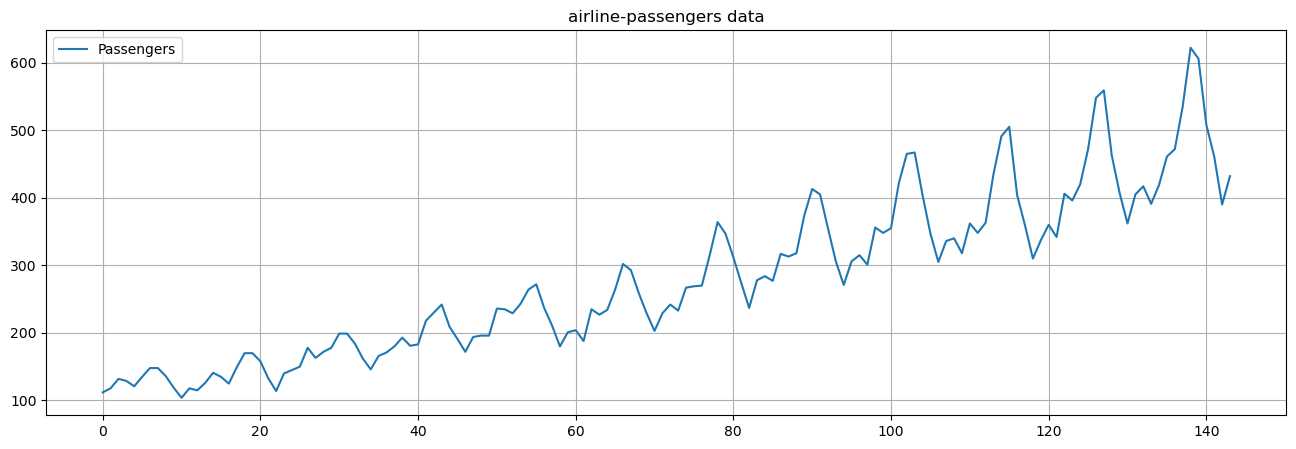

In [15]:
df.plot(figsize=(16,5))
plt.grid('On')
plt.title('airline-passengers data')
plt.show

In [16]:
df['month']=pd.to_datetime(df['Month']).dt.month
df['month']=df['month'].astype('int16')
df['year']=pd.to_datetime(df['Month']).dt.year-1949
df['year']=df['year'].astype('int16')
# #df.index = df.Month
df.drop(['Month'], axis=1, inplace=True)
df

,Passengers,month,year
0,112,1,0
1,118,2,0
2,132,3,0
3,129,4,0
4,121,5,0
...,...,...,...
139,606,8,11
140,508,9,11
141,461,10,11
142,390,11,11


In [17]:
data = df.copy()
train_split = 100
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int16
 1   month       144 non-null    int16
 2   year        144 non-null    int16
dtypes: int16(3)
memory usage: 992.0 bytes


In [18]:
data

,Passengers,month,year
0,112,1,0
1,118,2,0
2,132,3,0
3,129,4,0
4,121,5,0
...,...,...,...
139,606,8,11
140,508,9,11
141,461,10,11
142,390,11,11


#### Создаем данные для обучения

In [19]:
channelIndexes = [0, 1, 2] # Список признаков для обучения
bias = 2                # отступ тестов от тренировок

In [20]:
train_data = data.iloc[0: train_split, channelIndexes]
val_data = data.iloc[train_split+bias:, channelIndexes]

In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  100 non-null    int16
 1   month       100 non-null    int16
 2   year        100 non-null    int16
dtypes: int16(3)
memory usage: 728.0 bytes


In [22]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 102 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  42 non-null     int16
 1   month       42 non-null     int16
 2   year        42 non-null     int16
dtypes: int16(3)
memory usage: 384.0 bytes


In [23]:
features = train_data.columns[1:]
target = train_data.columns[0]

In [24]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,Passengers,month,year
0,112,-1.534863,-1.525724
1,118,-1.247435,-1.525724
2,132,-0.960008,-1.525724
3,129,-0.672580,-1.525724
4,121,-0.385153,-1.525724


#### Формируем данные для генерации выборки

In [25]:
# горизонт предсказаний
future = 1
# Длина истории для работы
x_len = 5   

batch_size = 5

In [26]:
start = x_len + future
end = start + train_split

print(start, end)

X_train = train_data[features].values
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

6 106
36 108


In [27]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 2), (100,), (36, 2), (36,))

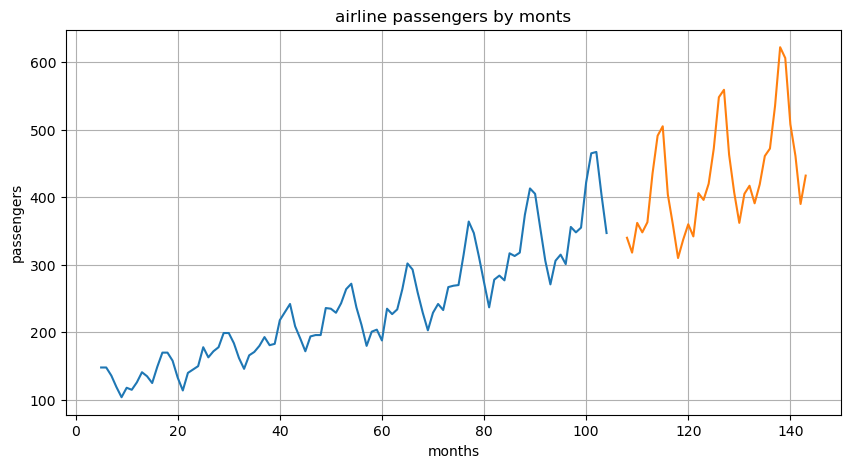

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid()
plt.xlabel('months')
plt.ylabel('passengers')
plt.title('airline passengers by monts')
plt.show()

In [29]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [30]:
for batch in dataset_train.take(1):
    inputs, targets = batch

In [31]:
logdir = os.path.join('hw_log', dt.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
callback = EarlyStopping(monitor='mae', patience=10)

In [32]:
(inputs.shape[1], inputs.shape[2])

(5, 2)

In [33]:
# параметры для модели обучения
learning_rate = 0.001
epochs = 100

result = pd.DataFrame() # сводная таблица результатов
model_name = [] # шаг
train_mae = [] # результат на трейне
val_mae = [] # результат на тесте

#### SimpleRNN

In [34]:
inputs_Simple = Input((inputs.shape[1], inputs.shape[2])) #.shape[1], inputs.shape[2]
x = SimpleRNN(32,return_sequences=True)(inputs_Simple)
x = Conv1D(64, 3, activation='linear')(x)
x = Conv1D(64, 1, activation='linear')(x)
x = Flatten()(x)
x = Dense(3, activation='linear')(x)
outputs_Simple = Dense(1, activation='linear')(x)
model_SimpleRNN = Model(inputs=inputs_Simple, outputs=outputs_Simple)

model_SimpleRNN.compile(optimizer='Adam', loss='mse', metrics=['mae'])

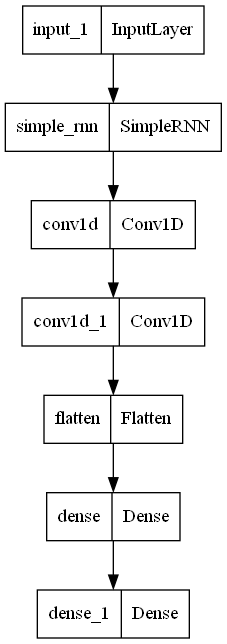

In [35]:
plot_model(model_SimpleRNN,to_file='model_SimpleRNN.png')

In [36]:
history_SimpleRNN = model_SimpleRNN.fit(
    dataset_train,
    epochs=epochs,
    validation_data = dataset_val,
    callbacks = [callback, tensorboard_callback]
)

Epoch 1/100
20/20 [==============================] - 3s 48ms/step - loss: 58299.2383 - mae: 228.7247 - val_loss: 192484.2344 - val_mae: 431.1132
Epoch 2/100
20/20 [==============================] - 0s 20ms/step - loss: 57038.4102 - mae: 226.1155 - val_loss: 188387.5312 - val_mae: 426.3813
Epoch 3/100
20/20 [==============================] - 0s 19ms/step - loss: 55991.9727 - mae: 224.5592 - val_loss: 180975.8125 - val_mae: 417.7291
Epoch 4/100
20/20 [==============================] - 0s 20ms/step - loss: 47269.5898 - mae: 208.4150 - val_loss: 126645.5312 - val_mae: 347.0660
Epoch 5/100
20/20 [==============================] - 0s 22ms/step - loss: 4965.1006 - mae: 62.2225 - val_loss: 10483.8359 - val_mae: 78.9212
Epoch 6/100
20/20 [==============================] - 0s 20ms/step - loss: 8870.8232 - mae: 77.8995 - val_loss: 23743.4805 - val_mae: 133.0862
Epoch 7/100
20/20 [==============================] - 0s 21ms/step - loss: 5523.7993 - mae: 57.5153 - val_loss: 15187.2666 - val_mae: 97.7

20/20 [==============================] - 0s 20ms/step - loss: 373.5378 - mae: 15.0666 - val_loss: 2676.2915 - val_mae: 39.1598
Epoch 60/100
20/20 [==============================] - 0s 21ms/step - loss: 368.6004 - mae: 14.9742 - val_loss: 2654.5176 - val_mae: 39.2129
Epoch 61/100
20/20 [==============================] - 0s 23ms/step - loss: 363.6819 - mae: 14.8850 - val_loss: 2633.9282 - val_mae: 39.2527
Epoch 62/100
20/20 [==============================] - 0s 20ms/step - loss: 358.7752 - mae: 14.7914 - val_loss: 2614.3943 - val_mae: 39.2790
Epoch 63/100
20/20 [==============================] - 0s 22ms/step - loss: 353.8746 - mae: 14.7106 - val_loss: 2595.7981 - val_mae: 39.2918
Epoch 64/100
20/20 [==============================] - 0s 20ms/step - loss: 348.9739 - mae: 14.6264 - val_loss: 2578.0186 - val_mae: 39.2909
Epoch 65/100
20/20 [==============================] - 0s 20ms/step - loss: 344.0669 - mae: 14.5374 - val_loss: 2560.9360 - val_mae: 39.2759
Epoch 66/100
20/20 [=============

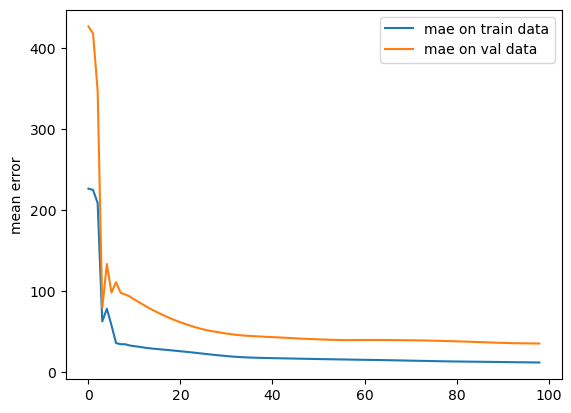

In [37]:
plt.plot(history_SimpleRNN.history['mae'][1:], label = 'mae on train data')
plt.plot(history_SimpleRNN.history['val_mae'][1:], label = 'mae on val data')
plt.ylabel('mean error')
plt.legend()
plt.show()

In [38]:
pred_SimpleRNN = model_SimpleRNN.predict(dataset_train).flatten()
pred_val_SimpleRNN = model_SimpleRNN.predict(dataset_val).flatten()

7/7 [==============================] - 0s 4ms/step


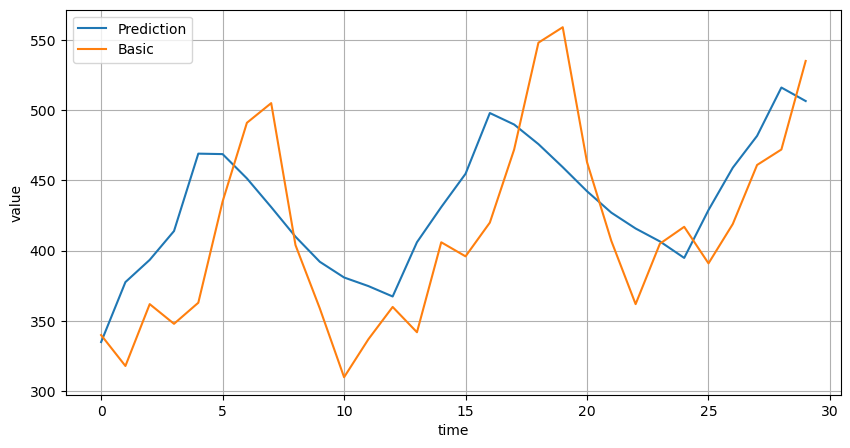

In [39]:
start = 0
step = 30
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_SimpleRNN[future + start: future + start + step], 
         label='Prediction')
plt.plot(y_val.flatten()[start:  start + step], 
         label='Basic')
plt.xlabel('time')
plt.ylabel('value')

plt.legend()
plt.show()

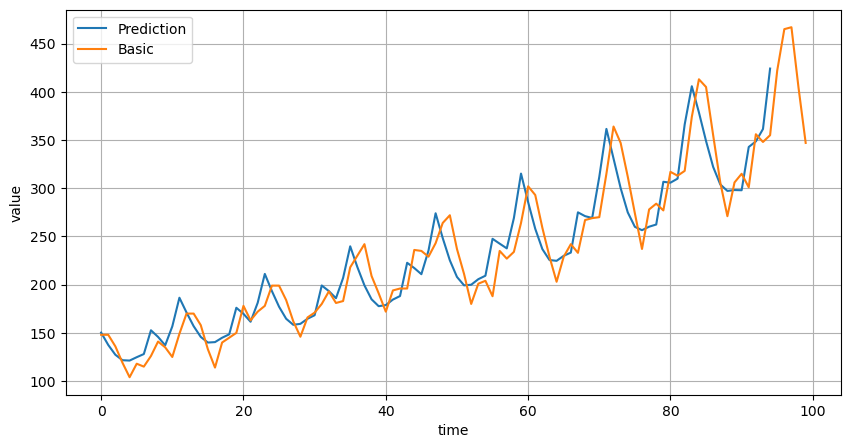

In [40]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_SimpleRNN[future + start: future + train_split], 
         label='Prediction')
plt.plot(y_train.flatten()[start: train_split], 
         label='Basic')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

In [41]:
train_loss, train_m = model_SimpleRNN.evaluate(dataset_train)
test_loss, val_m = model_SimpleRNN.evaluate(dataset_val)
print(f'train_loss: {train_loss}, train_mae: {train_m}')
print(f'val_loss: {test_loss}, val_mae: {val_m}')

model_name.append('SimpleRNN')
train_mae.append(round(train_m,2))
val_mae.append(round(val_m,2))

7/7 [==============================] - 0s 5ms/step - loss: 2123.0366 - mae: 34.9376
train_loss: 144.31581115722656, train_mae: 9.655644416809082
val_loss: 2123.03662109375, val_mae: 34.93756866455078


#### LSTM

In [42]:
inputs_LSTM = Input((inputs.shape[1], inputs.shape[2]))
x = LSTM(32,return_sequences=True)(inputs_LSTM)
x = LSTM(32,return_sequences=True)(x)
x = Conv1D(64, 3, activation='linear')(x)
x = Conv1D(64, 1, activation='linear')(x)
x = Flatten()(x)
x = Dense(3, activation='linear')(x)
outputs_LSTM = Dense(1, activation='linear')(x)
model_LSTM = Model(inputs=inputs_LSTM, outputs=outputs_LSTM)

model_LSTM.compile(optimizer='Adam', loss='mse', metrics=['mae'])

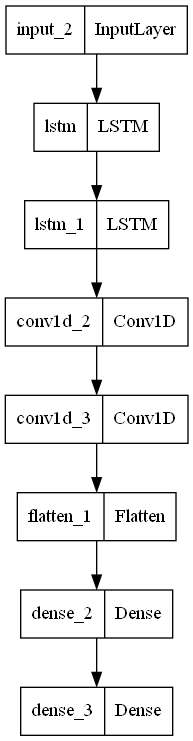

In [43]:
plot_model(model_LSTM,to_file='model_LSTM.png')

In [44]:
history_LSTM = model_LSTM.fit(
    dataset_train,
    epochs=epochs,
    validation_data = dataset_val,
    callbacks = [callback, tensorboard_callback]
)

Epoch 1/100
20/20 [==============================] - 6s 69ms/step - loss: 57410.4727 - mae: 227.4467 - val_loss: 188036.4531 - val_mae: 425.9405
Epoch 2/100
20/20 [==============================] - 0s 23ms/step - loss: 55112.0742 - mae: 222.8392 - val_loss: 178776.9375 - val_mae: 415.0595
Epoch 3/100
20/20 [==============================] - 0s 20ms/step - loss: 33595.3984 - mae: 175.9617 - val_loss: 82356.3438 - val_mae: 278.4532
Epoch 4/100
20/20 [==============================] - 0s 18ms/step - loss: 3448.5891 - mae: 48.5201 - val_loss: 4416.8213 - val_mae: 53.5275
Epoch 5/100
20/20 [==============================] - 0s 18ms/step - loss: 2262.9453 - mae: 41.2908 - val_loss: 4130.0615 - val_mae: 50.4005
Epoch 6/100
20/20 [==============================] - 0s 18ms/step - loss: 2547.1587 - mae: 43.1225 - val_loss: 3239.8816 - val_mae: 45.9694
Epoch 7/100
20/20 [==============================] - 0s 20ms/step - loss: 595.1388 - mae: 18.4596 - val_loss: 3490.3779 - val_mae: 46.5455
Epoch 8

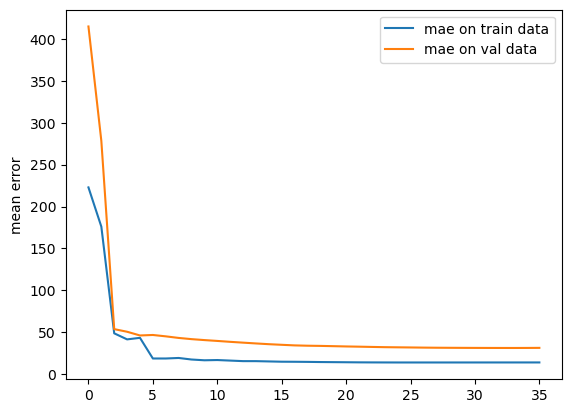

In [45]:
plt.plot(history_LSTM.history['mae'][1:], label = 'mae on train data')
plt.plot(history_LSTM.history['val_mae'][1:], label = 'mae on val data')
plt.ylabel('mean error')
plt.legend()
plt.show()

In [46]:
pred_LSTM = model_LSTM.predict(dataset_train).flatten()
pred_val_LSTM = model_LSTM.predict(dataset_val).flatten()

7/7 [==============================] - 0s 6ms/step


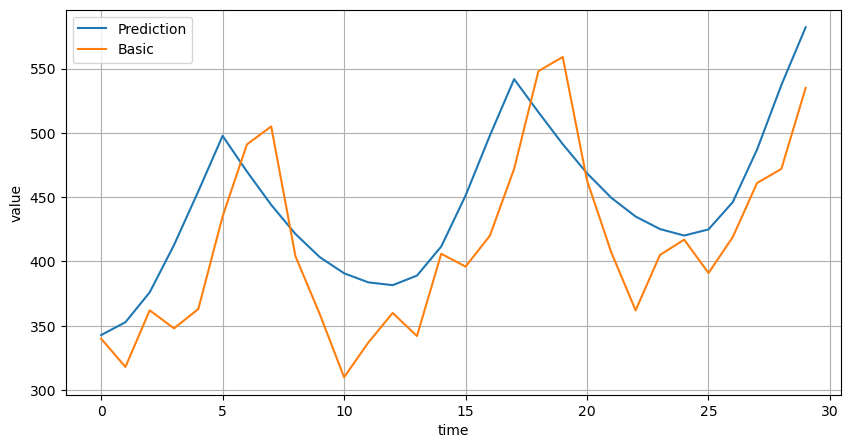

In [47]:
start = 0
step = 30
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_LSTM[future + start: future + start + step], 
         label='Prediction')
plt.plot(y_val.flatten()[start:  start + step], 
         label='Basic')
plt.xlabel('time')
plt.ylabel('value')

plt.legend()
plt.show()

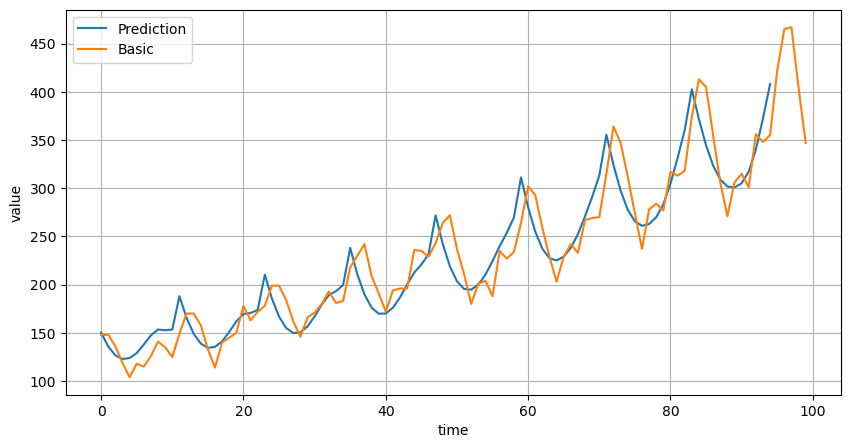

In [48]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_LSTM[future + start: future + train_split], 
         label='Prediction')
plt.plot(y_train.flatten()[start: train_split], 
         label='Basic')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

In [49]:
train_loss, train_m = model_LSTM.evaluate(dataset_train)
test_loss, val_m = model_LSTM.evaluate(dataset_val)
print(f'train_loss: {train_loss}, train_mae: {train_m}')
print(f'val_loss: {test_loss}, val_mae: {val_m}')

model_name.append('LSTM')
train_mae.append(round(train_m,2))
val_mae.append(round(val_m,2))

7/7 [==============================] - 0s 7ms/step - loss: 1478.9313 - mae: 31.1488
train_loss: 253.53619384765625, train_mae: 13.23698902130127
val_loss: 1478.9312744140625, val_mae: 31.148828506469727


#### GRU

In [50]:
inputs_GRU = Input((inputs.shape[1], inputs.shape[2])) #.shape[1], inputs.shape[2]
x = GRU(32,return_sequences=True, unroll=True)(inputs_GRU)
x = Conv1D(64, 3, activation='linear')(x)
x = Conv1D(64, 1, activation='linear')(x)
x = Flatten()(x)
x = Dense(3, activation='linear')(x)
outputs_GRU = Dense(1, activation='linear')(x)
model_GRU = Model(inputs=inputs_GRU, outputs=outputs_GRU)

model_GRU.compile(optimizer='Adam', loss='mse', metrics=['mae'])

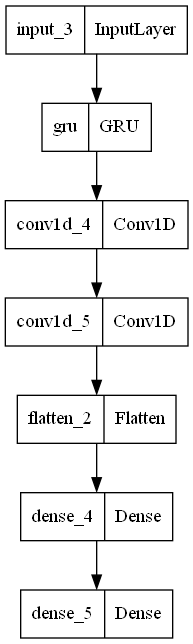

In [51]:
plot_model(model_GRU,to_file='model_GRU.png')

In [52]:
history_GRU = model_GRU.fit(
    dataset_train,
    epochs=epochs,
    validation_data = dataset_val,
    callbacks = [callback, tensorboard_callback]
)

Epoch 1/100
20/20 [==============================] - 3s 41ms/step - loss: 57763.7930 - mae: 228.0401 - val_loss: 189774.8281 - val_mae: 427.9996
Epoch 2/100
20/20 [==============================] - 1s 26ms/step - loss: 56832.7031 - mae: 226.0875 - val_loss: 186433.8594 - val_mae: 424.1420
Epoch 3/100
20/20 [==============================] - 0s 18ms/step - loss: 54118.8320 - mae: 221.0792 - val_loss: 171688.1562 - val_mae: 406.6544
Epoch 4/100
20/20 [==============================] - 0s 19ms/step - loss: 33430.1602 - mae: 176.5728 - val_loss: 76326.5859 - val_mae: 266.5071
Epoch 5/100
20/20 [==============================] - 0s 19ms/step - loss: 924.6387 - mae: 24.3186 - val_loss: 5372.9712 - val_mae: 53.3904
Epoch 6/100
20/20 [==============================] - 0s 19ms/step - loss: 1068.8146 - mae: 27.1979 - val_loss: 4064.7451 - val_mae: 46.7337
Epoch 7/100
20/20 [==============================] - 0s 18ms/step - loss: 1818.1718 - mae: 35.6530 - val_loss: 4922.1680 - val_mae: 50.4244
Ep

20/20 [==============================] - 0s 21ms/step - loss: 254.0849 - mae: 13.1758 - val_loss: 1436.3920 - val_mae: 31.4558
Epoch 60/100
20/20 [==============================] - 0s 21ms/step - loss: 252.4852 - mae: 13.1478 - val_loss: 1428.9779 - val_mae: 31.4323
Epoch 61/100
20/20 [==============================] - 0s 21ms/step - loss: 250.9382 - mae: 13.1191 - val_loss: 1422.3572 - val_mae: 31.4138
Epoch 62/100
20/20 [==============================] - 0s 20ms/step - loss: 249.3555 - mae: 13.0885 - val_loss: 1416.1106 - val_mae: 31.3944
Epoch 63/100
20/20 [==============================] - 0s 22ms/step - loss: 247.8586 - mae: 13.0587 - val_loss: 1410.7435 - val_mae: 31.3819
Epoch 64/100
20/20 [==============================] - 0s 21ms/step - loss: 246.2776 - mae: 13.0222 - val_loss: 1405.4768 - val_mae: 31.3653
Epoch 65/100
20/20 [==============================] - 0s 21ms/step - loss: 244.8490 - mae: 12.9902 - val_loss: 1401.3333 - val_mae: 31.3595
Epoch 66/100
20/20 [=============

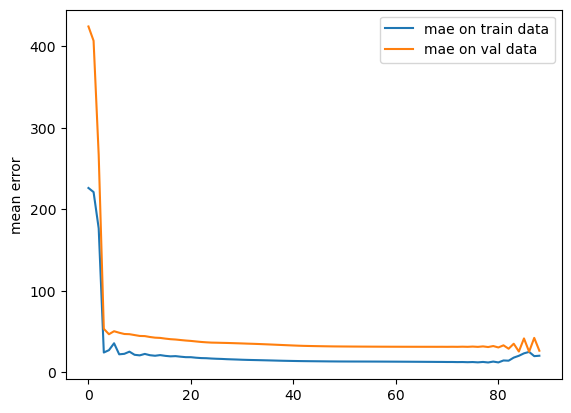

In [53]:
plt.plot(history_GRU.history['mae'][1:], label = 'mae on train data')
plt.plot(history_GRU.history['val_mae'][1:], label = 'mae on val data')
plt.ylabel('mean error')
plt.legend()
plt.show()

In [54]:
pred_GRU = model_GRU.predict(dataset_train).flatten()
pred_val_GRU = model_GRU.predict(dataset_val).flatten()

7/7 [==============================] - 0s 6ms/step


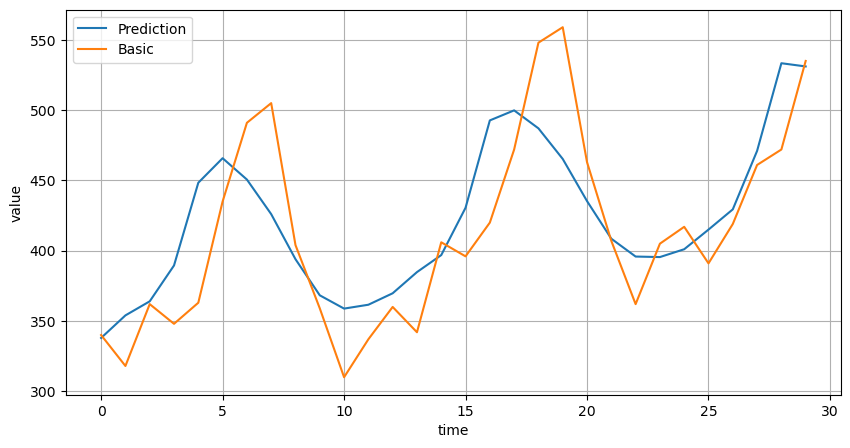

In [55]:
start = 0
step = 30
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_GRU[future + start: future + start + step], 
         label='Prediction')
plt.plot(y_val.flatten()[start:  start + step], 
         label='Basic')
plt.xlabel('time')
plt.ylabel('value')

plt.legend()
plt.show()

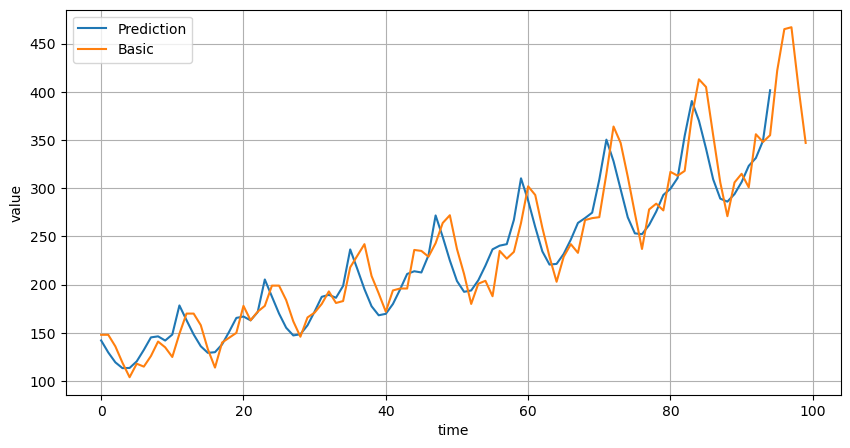

In [56]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_GRU[future + start: future + train_split], 
         label='Prediction')
plt.plot(y_train.flatten()[start: train_split], 
         label='Basic')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

In [57]:
train_loss, train_m = model_GRU.evaluate(dataset_train)
test_loss, val_m = model_GRU.evaluate(dataset_val)
print(f'train_loss: {train_loss}, train_mae: {train_m}')
print(f'val_loss: {test_loss}, val_mae: {val_m}')

model_name.append('GRU')
train_mae.append(round(train_m,2))
val_mae.append(round(val_m,2))

7/7 [==============================] - 0s 8ms/step - loss: 1263.7375 - mae: 26.5145
train_loss: 186.3092803955078, train_mae: 11.170684814453125
val_loss: 1263.737548828125, val_mae: 26.514541625976562


#### GRU+LSTM

In [58]:
inputs_GRU_LSTM = Input((inputs.shape[1], inputs.shape[2])) #.shape[1], inputs.shape[2]
x = GRU(32,return_sequences=True, unroll=True)(inputs_GRU_LSTM)
x = LSTM(32,return_sequences=True)(x)
x = Conv1D(64, 3, activation='linear')(x)
x = Conv1D(64, 1, activation='linear')(x)
x = Flatten()(x)
outputs_GRU_LSTM = Dense(1, activation='linear')(x)
model_GRU_LSTM = Model(inputs=inputs_GRU_LSTM, outputs=outputs_GRU_LSTM)

model_GRU_LSTM.compile(optimizer='Adam', loss='mse', metrics=['mae'])

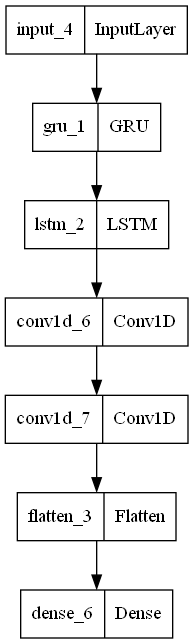

In [59]:
plot_model(model_GRU_LSTM,to_file='model_GRU_LSTM.png')

In [60]:
history_GRU_LSTM = model_GRU_LSTM.fit(
    dataset_train,
    epochs=epochs,
    validation_data = dataset_val,
    callbacks = [callback, tensorboard_callback]
)

Epoch 1/100
20/20 [==============================] - 5s 74ms/step - loss: 57547.3711 - mae: 227.6771 - val_loss: 188680.7500 - val_mae: 426.6844
Epoch 2/100
20/20 [==============================] - 1s 27ms/step - loss: 56662.7617 - mae: 225.8141 - val_loss: 186126.1250 - val_mae: 423.6921
Epoch 3/100
20/20 [==============================] - 0s 21ms/step - loss: 48248.4023 - mae: 208.9896 - val_loss: 154079.8125 - val_mae: 383.9644
Epoch 4/100
20/20 [==============================] - 0s 20ms/step - loss: 1707.2109 - mae: 33.4773 - val_loss: 10432.1621 - val_mae: 76.7138
Epoch 5/100
20/20 [==============================] - 0s 21ms/step - loss: 30443.3203 - mae: 139.4886 - val_loss: 46222.1875 - val_mae: 202.0685
Epoch 6/100
20/20 [==============================] - 0s 21ms/step - loss: 2361.5237 - mae: 39.9406 - val_loss: 15242.7773 - val_mae: 100.3417
Epoch 7/100
20/20 [==============================] - 0s 24ms/step - loss: 1622.5216 - mae: 33.9707 - val_loss: 10276.5703 - val_mae: 75.39

20/20 [==============================] - 0s 23ms/step - loss: 311.4934 - mae: 14.3199 - val_loss: 1705.5192 - val_mae: 32.3810
Epoch 60/100
20/20 [==============================] - 0s 21ms/step - loss: 309.9137 - mae: 14.3157 - val_loss: 1682.8171 - val_mae: 32.2251
Epoch 61/100
20/20 [==============================] - 0s 22ms/step - loss: 308.3596 - mae: 14.3067 - val_loss: 1662.1741 - val_mae: 32.0809
Epoch 62/100
20/20 [==============================] - 1s 25ms/step - loss: 306.8125 - mae: 14.2940 - val_loss: 1643.4242 - val_mae: 31.9475
Epoch 63/100
20/20 [==============================] - 1s 28ms/step - loss: 305.2604 - mae: 14.2817 - val_loss: 1626.4108 - val_mae: 31.8241
Epoch 64/100
20/20 [==============================] - 1s 27ms/step - loss: 303.6967 - mae: 14.2652 - val_loss: 1610.9813 - val_mae: 31.7097
Epoch 65/100
20/20 [==============================] - 0s 24ms/step - loss: 302.1173 - mae: 14.2450 - val_loss: 1596.9969 - val_mae: 31.6035
Epoch 66/100
20/20 [=============

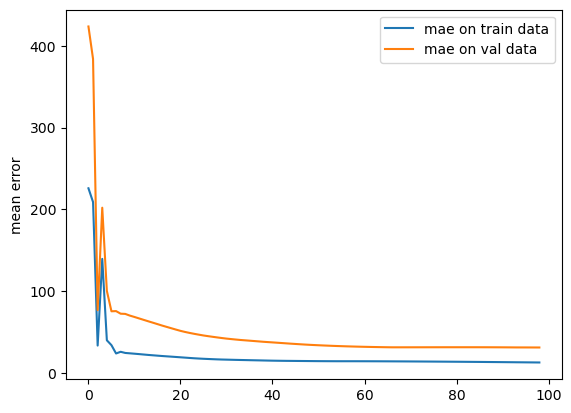

In [61]:
plt.plot(history_GRU_LSTM.history['mae'][1:], label = 'mae on train data')
plt.plot(history_GRU_LSTM.history['val_mae'][1:], label = 'mae on val data')
plt.ylabel('mean error')
plt.legend()
plt.show()

In [62]:
pred_GRU_LSTM = model_GRU_LSTM.predict(dataset_train).flatten()
pred_val_GRU_LSTM = model_GRU_LSTM.predict(dataset_val).flatten()

7/7 [==============================] - 0s 8ms/step


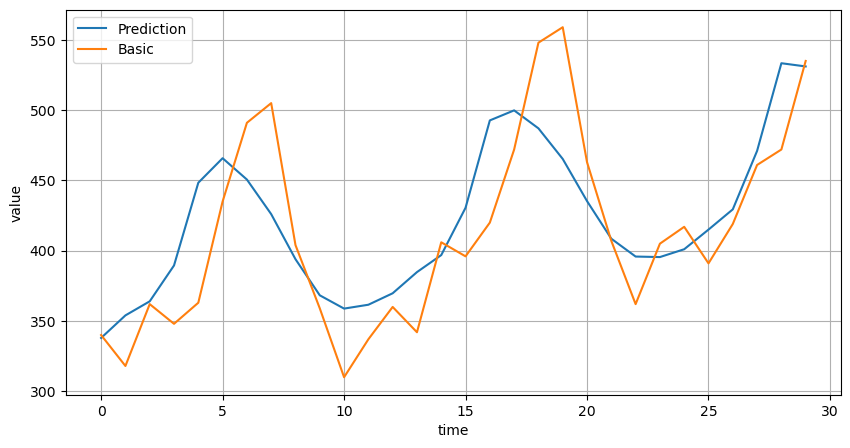

In [63]:
start = 0
step = 30
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_GRU[future + start: future + start + step], 
         label='Prediction')
plt.plot(y_val.flatten()[start:  start + step], 
         label='Basic')
plt.xlabel('time')
plt.ylabel('value')

plt.legend()
plt.show()

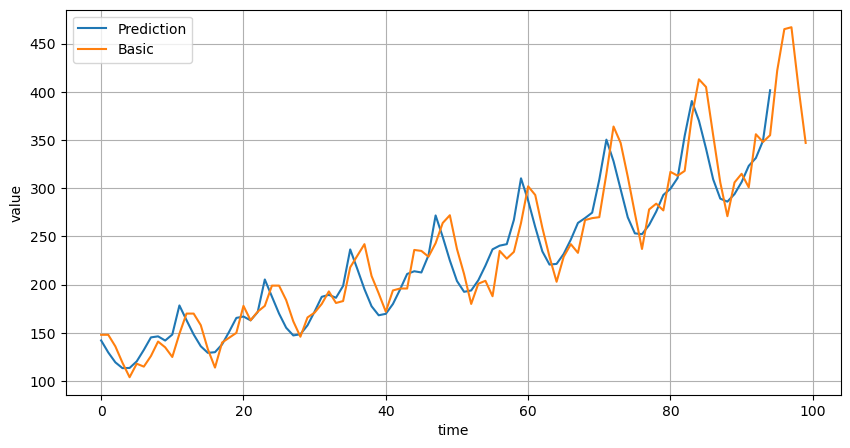

In [64]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_GRU[future + start: future + train_split], 
         label='Prediction')
plt.plot(y_train.flatten()[start: train_split], 
         label='Basic')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

In [65]:
train_loss, train_m = model_GRU_LSTM.evaluate(dataset_train)
test_loss, val_m = model_GRU_LSTM.evaluate(dataset_val)

print(f'train_loss: {train_loss}, train_mae: {train_m}')
print(f'val_loss: {test_loss}, val_mae: {val_m}')

model_name.append('GRU_LSTM')
train_mae.append(round(train_m,2))
val_mae.append(round(val_m,2))

7/7 [==============================] - 0s 10ms/step - loss: 1446.3563 - mae: 31.1159
train_loss: 176.332763671875, train_mae: 10.965934753417969
val_loss: 1446.3563232421875, val_mae: 31.115875244140625


In [66]:
result['Name'] = model_name
result['train_mae'] = train_mae
result['val_mae'] = val_mae
result.sort_values(by=['val_mae'], axis=0, ascending=True, inplace=True)
result

,Name,train_mae,val_mae
2,GRU,11.17,26.51
3,GRU_LSTM,10.97,31.12
1,LSTM,13.24,31.15
0,SimpleRNN,9.66,34.94


In [67]:
%tensorboard --logdir hw_log --bind_all

In [68]:
!nvidia-smi

Sun Feb 26 16:15:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.00       Driver Version: 517.00       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:06:00.0 Off |                  N/A |
| N/A   63C    P8    N/A /  N/A |   1412MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [69]:
# cuda.close()

In [70]:
# !kill 4188